In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.plot_util import assess_constraints, pairplot
from dsn.util.dsn_util import get_system_from_template
import seaborn as sns
import pandas as pd
import warnings
import scipy
import time
warnings.filterwarnings("ignore")
import os

os.chdir('../../')

In [17]:
sysname = 'V1Circuit'
behavior_type = "difference"
param_dict = {'behavior_type':behavior_type,
              'ISN':'pos',
              'silenced':'V'}
system = get_system_from_template(sysname, param_dict)

{'type': 'difference', 'mean': 0.1, 'std': 0.01, 'c_vals': array([1.]), 's_vals': array([5]), 'r_vals': array([0., 1.]), 'silenced': 'V'}
difference


In [18]:
print(system.free_params)

['h_RUNE', 'h_RUNP', 'h_RUNS', 'h_RUNV']


In [19]:
np.random.seed(0)
M = 2000

min_h = -10.0
max_h = 10.0
# column 2
h_RUNE = np.random.uniform(min_h, max_h, (M,))
h_RUNP = np.random.uniform(min_h, max_h, (M,))
h_RUNS = np.random.uniform(min_h, max_h, (M,))
h_RUNV = np.random.uniform(min_h, max_h, (M,))

_Z = np.stack((h_RUNE, h_RUNP, h_RUNS, h_RUNV), axis=1)
_Z = np.expand_dims(_Z, 0)


In [20]:

num_params = system.D;
Z = tf.placeholder(dtype=tf.float64, shape=(1, None, num_params));

sess = tf.Session()
T_x = system.simulation_suff_stats(Z)
r_t = system.simulate(Z)

In [21]:

_T_x, _r_t = sess.run([T_x, r_t], {Z:_Z});


In [22]:
r_ss_E = _r_t[-1,1,:,0,0]
r_ss_P = _r_t[-1,1,:,1,0]
r_ss_S = _r_t[-1,1,:,2,0]
r_ss_V = _r_t[-1,1,:,3,0]

r_ss = _r_t[-1, 1, :, :, 0]

u_E = np.sqrt(_r_t[-1,1,:,0,0])
betas = 1 - 2*u_E*system.fixed_params['W_EE']

plot_th = 1e2
stable_inds = np.logical_and(np.logical_and(r_ss_E < plot_th, r_ss_P < plot_th), np.logical_and(r_ss_S < plot_th, r_ss_V < plot_th))
E_on = r_ss_E > 1e-2
plot_inds = np.logical_and(E_on, stable_inds)

In [23]:
print(betas)
print(np.sum(plot_inds))

[ 0.99998435 -0.252715    0.48794038 ...  0.99998605 -0.40620848
 -0.31371804]
540


In [24]:
t = np.linspace(0.0, system.dt*(system.T-1), system.T)
black = 'k'
red =  [0.8, 0.0, 0.0]
blue = [0.0, 0.0, 0.8]
green = [0.0, 0.8, 0.0]

In [25]:
plot_traces = False
if (plot_traces):
    r_ss_E = np.zeros((M,))
    for i in range(M):
        if (plot_inds[i]):
            plt.figure()
            plt.plot(t, _r_ts[0][:,0,i,0,0], '-', c=black)
            plt.plot(t, _r_ts[0][:,0,i,1,0], '--', c=blue)
            plt.plot(t, _r_ts[0][:,0,i,2,0],'-',  c=red)
            plt.plot(t, _r_ts[0][:,0,i,3,0], '--', c=green)
            plt.legend(['E', 'P', 'S', 'V'])
            plt.xlabel('time')
            plt.ylabel('r(t)')
            ax = plt.gca()
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            plt.show()

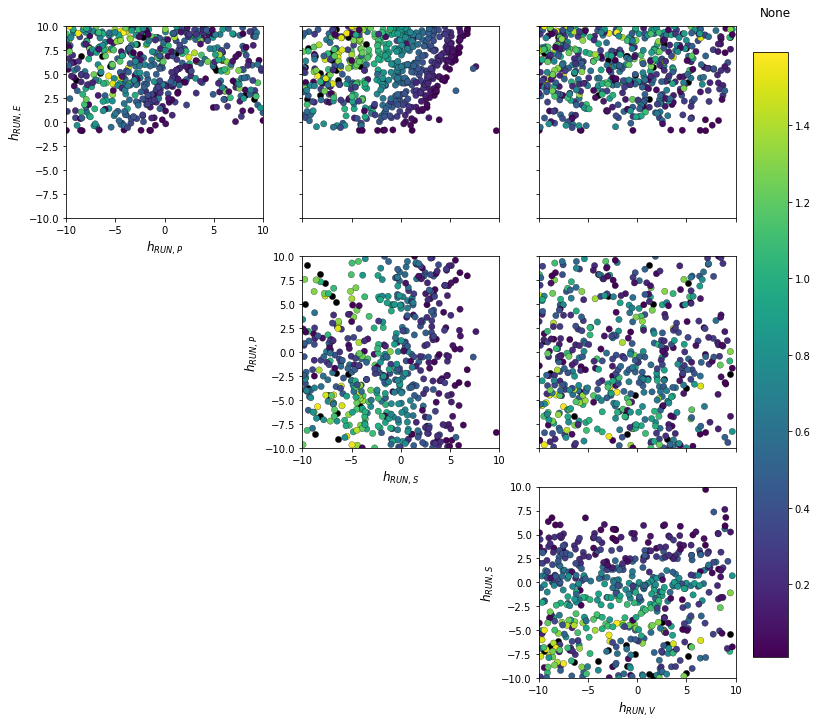

In [26]:
fig = pairplot(_Z[0,plot_inds], range(system.D), system.z_labels, 
               c=r_ss_E[plot_inds], xlims=[min_h, max_h], ylims=[min_h, max_h])

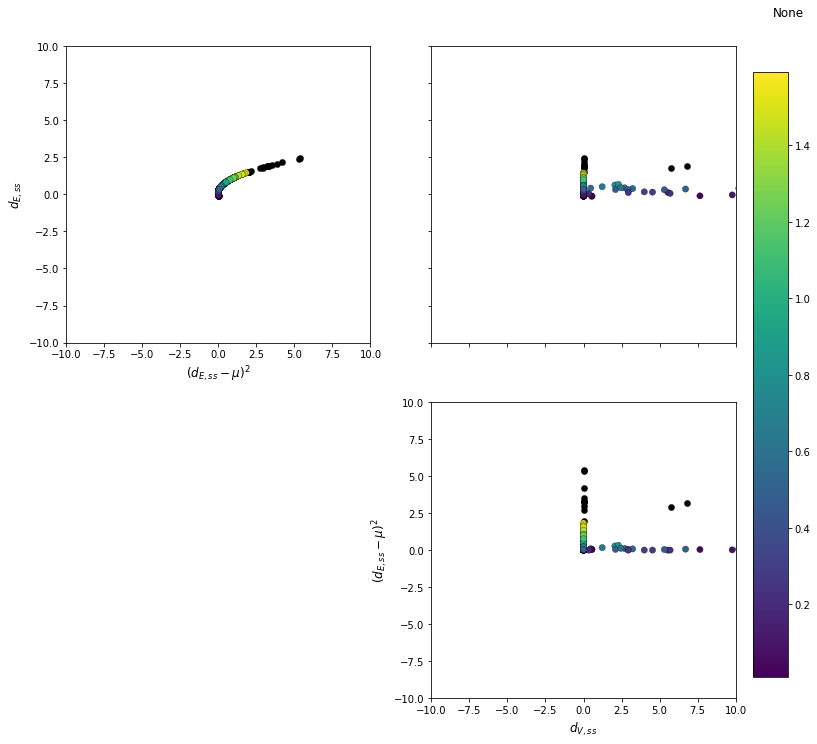

In [29]:
fig = pairplot(_T_x[0,plot_inds], range(system.num_suff_stats), system.T_x_labels, 
               c=r_ss_E[plot_inds], xlims=[min_h, max_h], ylims=[min_h, max_h])

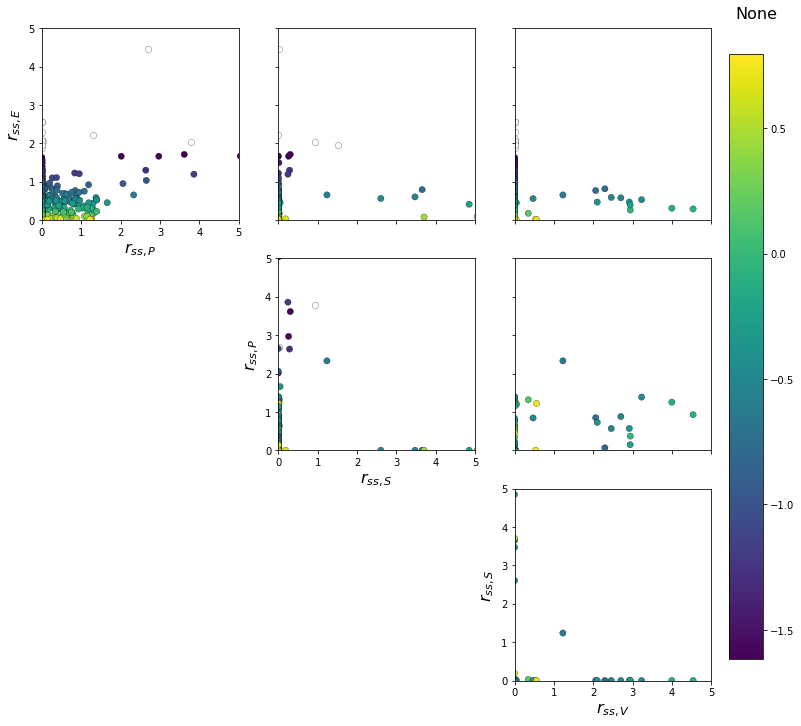

In [30]:
labels = [r'$r_{ss,E}$', r'$r_{ss,P}$', r'$r_{ss,S}$', r'$r_{ss,V}$']
fig = pairplot(r_ss[plot_inds], range(4), labels, c=betas[plot_inds], 
               fontsize=16, xlims=[0,5], ylims=[0,5])